# Emotion Detection using CNN-LSTM





1.   Mubbara Majid (SP23-BAI-027)
2.   Noor Fatima (SP23-BAI-046)



In [ ]:
!pip install tensorflow

In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 17.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 req

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Data Loading and analyzing

In [ ]:
df = pd.read_parquet("/content/train-00000-of-00001.parquet")

In [ ]:
df.head(5)

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2


In [ ]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of rows: 416809
Number of columns: 2


In [ ]:
df['label'].unique()

array([0, 1, 2, 3, 4, 5])

This is a 6-class problem.

In [ ]:
label_counts = df['label'].value_counts()
display(label_counts)

,count
label,
1,141067
0,121187
3,57317
4,47712
2,34554
5,14972


# Data Preprocessing

## Check Missing and Duplicate values

In [ ]:
df.isnull().sum()

,0
text,0
label,0


In [ ]:
print('Duplicates: ', df.duplicated().sum())

Duplicates:  686


In [ ]:
df = df.drop_duplicates()

print("Duplicates remaining:", df.duplicated().sum())


Duplicates remaining: 0


## Lowercasing

In [ ]:
df['text'] = df['text'].str.lower()

In [ ]:
df.loc[4, ['text']]

,4
text,i beleive that i am much more sensitive to oth...


## Remove unnecessary elements

In [ ]:
import re

In [ ]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)    # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove punctuations and numbers
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text.strip()

In [ ]:
df['text'] = df['text'].apply(clean_text)

## Stop words removal

In [ ]:
import nltk
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = stopwords.words('english')

In [ ]:
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [ ]:
df.head(5)

,text,label
0,feel awful job get position succeed happen,0
1,im alone feel awful,0
2,ive probably mentioned really feel proud actua...,1
3,feeling little low days back,0
4,beleive much sensitive peoples feelings tend c...,2


## Check class imbalance

<Axes: xlabel='label'>

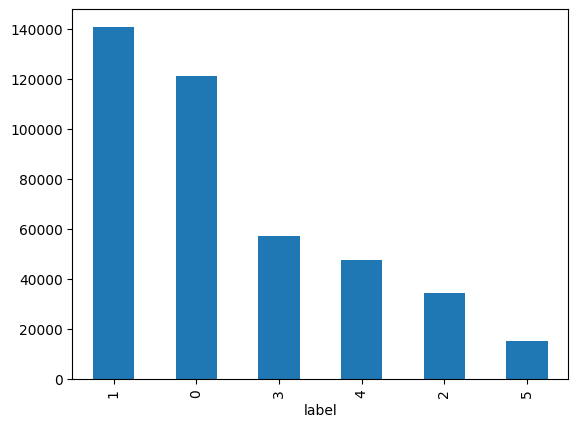

In [ ]:
df['label'].value_counts().plot(kind='bar')

The lowest class has ~10X fewer samples than the top class — this will bias the model toward the majority classes, lowering F1-score for minority emotions.

Best way is to tell the model to "care more" about underrepresented classes.

### Class Weights (Recommended for LSTM/CNN)

In [ ]:
from sklearn.utils import class_weight

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label']),
    y=df['label']
)

class_weights_dict = dict(enumerate(class_weights))

The class_weights_dict will be used during model.fit.

## Tokenization and Padding

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
MAX_LEN = 150
VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])

In [ ]:
sequences = tokenizer.texts_to_sequences(df['text'])
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

## Word2Vec Embedding Matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from gensim.models import KeyedVectors
model_path = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin'

w2v_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [ ]:
print(w2v_model['king'])        # Word embedding vector
print(w2v_model.vector_size)     # Should return 300

[ 1.25976562e-01  2.97851562e-02  8.60595703e-03  1.39648438e-01
 -2.56347656e-02 -3.61328125e-02  1.11816406e-01 -1.98242188e-01
  5.12695312e-02  3.63281250e-01 -2.42187500e-01 -3.02734375e-01
 -1.77734375e-01 -2.49023438e-02 -1.67968750e-01 -1.69921875e-01
  3.46679688e-02  5.21850586e-03  4.63867188e-02  1.28906250e-01
  1.36718750e-01  1.12792969e-01  5.95703125e-02  1.36718750e-01
  1.01074219e-01 -1.76757812e-01 -2.51953125e-01  5.98144531e-02
  3.41796875e-01 -3.11279297e-02  1.04492188e-01  6.17675781e-02
  1.24511719e-01  4.00390625e-01 -3.22265625e-01  8.39843750e-02
  3.90625000e-02  5.85937500e-03  7.03125000e-02  1.72851562e-01
  1.38671875e-01 -2.31445312e-01  2.83203125e-01  1.42578125e-01
  3.41796875e-01 -2.39257812e-02 -1.09863281e-01  3.32031250e-02
 -5.46875000e-02  1.53198242e-02 -1.62109375e-01  1.58203125e-01
 -2.59765625e-01  2.01416016e-02 -1.63085938e-01  1.35803223e-03
 -1.44531250e-01 -5.68847656e-02  4.29687500e-02 -2.46582031e-02
  1.85546875e-01  4.47265

Embedding matrix

In [ ]:
embedding_dim = w2v_model.vector_size
word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in w2v_model:
        embedding_matrix[i] = w2v_model[word]

## Label Encoding

In [ ]:
from keras.utils import to_categorical

labels = to_categorical(df['label'])

In [ ]:
print("Padded sequences shape:", padded.shape)
print("Embedding matrix shape:", embedding_matrix.shape)
print("Labels shape:", labels.shape)

Padded sequences shape: (416123, 100)
Embedding matrix shape: (75135, 300)
Labels shape: (416123, 6)


# Build and Train model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42, stratify=labels)

In [ ]:
model = Sequential()
model.add(Embedding(
    input_dim=len(word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=MAX_LEN,
    trainable=False
))

model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(6, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │      22,540,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,540,500 (85.99 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 22,540,500 (85.99 MB)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/10
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 75s 26ms/step - accuracy: 0.7144 - loss: 0.7047 - val_accuracy: 0.9201 - val_loss: 0.1886
Epoch 2/10
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 71s 27ms/step - accuracy: 0.9246 - loss: 0.1707 - val_accuracy: 0.9270 - val_loss: 0.1519
Epoch 3/10
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 72s 24ms/step - accuracy: 0.9311 - loss: 0.1420 - val_accuracy: 0.9315 - val_loss: 0.1471
Epoch 4/10
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 87s 26ms/step - accuracy: 0.9343 - loss: 0.1321 - val_accuracy: 0.9340 - val_loss: 0.1335
Epoch 5/10
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 80s 25ms/step - accuracy: 0.9359 - loss: 0.1263 - val_accuracy: 0.9311 - val_loss: 0.1448
Epoch 6/10
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 79s 24ms/step - accuracy: 0.9380 - loss: 0.1212 - val_accuracy: 0.9352 - val_loss: 0.1292
Epoch 7/10
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 89s 27ms/step - accuracy: 0.9384 - loss: 0.1184 - val_accuracy: 0.9366 - val_loss: 0.1312
Epoch 8/10
2601/2601 ━━━━━━━━━━━━━━━━━━━━ 63s 24ms/step - accuracy: 0.9401 -

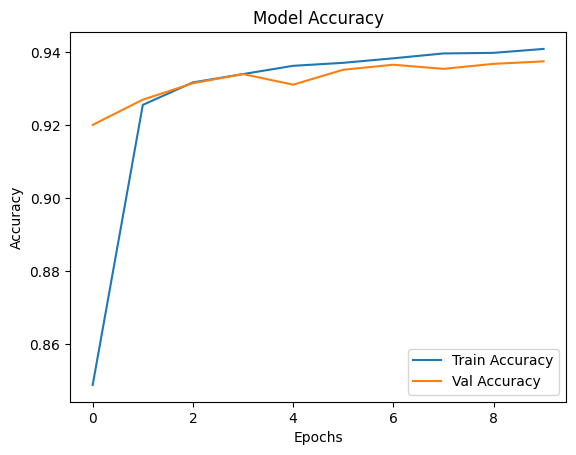

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

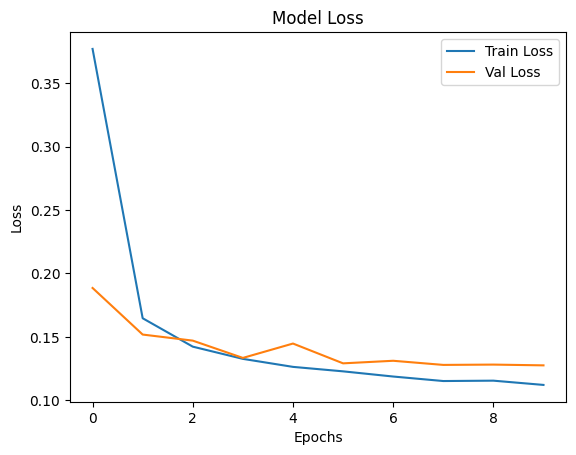

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
y_hat_probs = model.predict(X_test)

2601/2601 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step


In [ ]:
y_pred = np.argmax(y_hat_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0     0.9956    0.9510    0.9728     24198
           1     0.9950    0.9108    0.9510     28156
           2     0.7661    0.9977    0.8667      6899
           3     0.9068    0.9875    0.9454     11447
           4     0.9334    0.8604    0.8954      9533
           5     0.7263    0.9950    0.8397      2992

    accuracy                         0.9375     83225
   macro avg     0.8872    0.9504    0.9118     83225
weighted avg     0.9473    0.9375    0.9392     83225



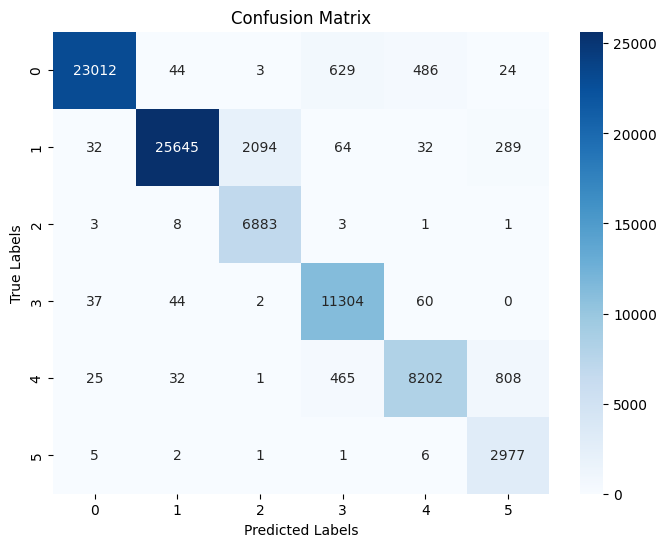

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Summary

The project builds a 6-class text classifier using Word2Vec embeddings with a CNN + Bi-LSTM model in Keras.


It achieved an overall accuracy of 93.75%, with a macro F1-score of 91.18% and weighted F1-score of 93.92%.


The model handles class imbalance well and generalizes effectively across all classes.